# NAU Monsoon

This script configures a scaffold in which to run epymorph simulations on Monsoon,

NAU's high-performance computing cluster powered by Slurm. https://in.nau.edu/arc/

The ins-and-outs of using Monsoon are important but beyond this help text,

so follow Monsoon's training first!

### Goals

This script does the following:

[ ] clone the epymorph repository (/home/$USER/epymorph)

[ ] create a separate folder for simulation scripts (/home/$USER/epymorph-jobs)

[ ] set up a venv and install epymorph's dependencies to make it runnable

[ ] set up a .env configuration file -- with some placeholders for you to replace!

[ ] create a folder for outputs (/scratch/$USER/epymorph-jobs)

[ ] create an example Slurm batch job runner script (job.sh)

[ ] create an example epymorph simulation runner script (example-job.py)

After running this script successfully, you will be able to launch an array batch job

that runs 10 simulations in parallel and writes their results file, console output,

and error output (which is hopefully empty) to the outputs directory identified by job ID.

### === GitHub Credentials (PAT) ===

In order to clone the epymorph repo (because it is not currently public) you will first need

to set up a Personal Access Token (PAT). https://github.com/settings/tokens?type=beta

Here are some recommended settings when generating a PAT:

- Expiration: can be up to a year out, which is fine

- Resource Owner: NAU-CCL

- Only select repositories; Epymorph

- Repository permissions:

- Contents: Read-only

- Metadata: Read-only

You will use that to authenticate when the script prompts you -- use your GitHub username

as the username and the PAT itself as your password.

New PATs may require NAU-CCL admin approval before they are active.

### === Why the two job files? (job.sh and example-job.py) ===

The job.sh file configures Slurm job settings and executes Python with a proper environment.

The example-job.py file is where the simulation is configured and run, and where the results

are dealt with. The job.sh file is designed to be re-usable (maybe with small modifications)

while the \*.py file is designed to be specific to your simulation task.

### === Usage ===

Once you're set up with Monsoon access and logged in, copy this script into your

home directory and make it runnable:

chmod +x ./setup-epymorph-monsoon.sh

Then run it:

./setup-epymorph-monsoon.sh

### === Handy Info ===

Read more about which configuration settings are available for starting Slurm jobs:

https://slurm.schedmd.com/sbatch.html#SECTION_OPTIONS

Read more about which environment variables are made available inside your Slurm job:

https://slurm.schedmd.com/sbatch.html#SECTION_OUTPUT-ENVIRONMENT-VARIABLES


# Setting up EpyMoRPH onto Monsoon


In [ ]:
set -euo pipefail

dir=~
echo "Setting up epymorph project in $dir"
cd $dir

## Clone epymorph repo

Save the provided token github provides you as this will be used for your password.


In [ ]:
if [ ! -d "epymorph" ]; then
    echo ""
    echo "You will first need to set up a PAT with read-access to the repo contents & metadata."
    echo "  https://github.com/settings/tokens?type=beta"
    echo "  (You may need admin approval before the token is active.)"
    echo "Provide your user name and use the PAT as your password when prompted..."
    echo ""

    git clone https://github.com/NAU-CCL/Epymorph.git epymorph
fi

## Set up jobs folder and output space


In [ ]:
out_dir=/scratch/$USER/epymorph-jobs
mkdir -p $out_dir

prj_dir=/home/$USER/epymorph-jobs
mkdir -p $prj_dir
cd $prj_dir

if [ ! -d ".venv" ]; then
    python3.11 -m venv .venv
    source .venv/bin/activate
    pip install -U pip
    pip install ../epymorph
else
    source .venv/bin/activate
fi

## Create env file for secrets.

You will need to update CENSUS_API_TOKEN with your own Census API key

if you do not have a census api key yet sign up for one using this link

https://api.census.gov/data/key_signup.html


In [ ]:

tee .env >/dev/null <<EOF
EPYMORPH_CACHE_PATH=/scratch/$USER/.cache/epymorph
CENSUS_API_TOKEN=changeme
EOF

## Create job runner shell script.

Changes that will need to be made before you run your own simulation on monsoon

- SBATCH --job-name=epymorph
  - Something
- SBATCH --output=/scratch/%u/epymorph-jobs/job*%A/stdout*%a.txt
  - The name of the text file after a successful simulation run
  - This will be used later when compling the simulation results together
  - Name this file with the apporiate name for other technician to understand
  - %a indicate the simulation run
- SBATCH --error=/scratch/%u/epymorph-jobs/job*%A/stderr*%a.txt
  - The name of the text file if the simulation encounter an error
- SBATCH --time=1:00
  - This means the job will only run for one minute and will be increase for more complicated models
- SBATCH --mem=192
  - Increase this memory for more complicated models
- SBATCH --array=1-8
  - This is how many simulations Monsoon will be running


In [ ]:
tee job.sh >/dev/null <<'EOF'
#!/bin/bash
#SBATCH --job-name=epymorph
#SBATCH --output=/scratch/%u/epymorph-jobs/job_%A/stdout_%a.txt
#SBATCH --error=/scratch/%u/epymorph-jobs/job_%A/stderr_%a.txt
#SBATCH --time=1:00
#SBATCH --mem=192
#SBATCH --cpus-per-task=1
#SBATCH --array=1-8
set -euo pipefail

cd ~/epymorph-jobs

## Run a Python script given as the first argument


In [ ]:
if [ $# -eq 0 ]; then
    echo "Error: No Python script provided."
    echo "Usage: $0 <script.py>"
    exit 1
fi

if [ ! -f "$1" ]; then
    echo "Error: File not found: $1"
    echo "Usage: $0 <script.py>"
    exit 1
fi

source .venv/bin/activate

env_file=.env
if [ -f "$env_file" ]; then
    export $(cat "$env_file" | xargs)
    echo "loaded $env_file"
fi

echo "starting job: $(pwd)/$1"
echo "which python: $(which python) ($(python -V))"

python "$1"

deactivate
echo "job complete"
EOF


## Create example python job script.


In [ ]:

scope = BlockGroupScope.in_counties(counties_fips = ["04013"], year = 2019)

rume = SingleStrataRume.build(
    ipm=sirh_ipm,
    mm=mm_library["no"](),
    scope=scope,
    params={
        "beta": 0.45,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "population": acs5.Population(),
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    init=init.SingleLocation(location=0, seed_size=100),
)


In [ ]:
tee example-job.py >/dev/null <<'EOF'
import os

import numpy as np

from epymorph import *

def main():
    geo = geo_library['pei']()
    rume = Rume.single_strata(
        ipm=ipm_library['pei'](),
        mm=mm_library['pei'](),
        scope=geo.spec.scope,
        init=init.SingleLocation(location=0, seed_size=1_000),
        time_frame=TimeFrame.of("2015-01-01", 365),
        params={
            'theta': 0.1,
            'move_control': 0.9,
            'infection_duration': 4,
            'immunity_duration': 90,
            'centroid': geo['centroid'],
            'population': geo['population'],
            'commuters': geo['commuters'],
            'humidity': geo['humidity'],
            'meta::geo::label': geo['label'],
        },
    )

    sim = BasicSimulator(rume)
    with sim_messaging(sim):
        out = sim.run()

    user = os.getenv("USER")
    job_id = os.getenv("SLURM_ARRAY_JOB_ID", "?")
    task_id = os.getenv("SLURM_ARRAY_TASK_ID", "?")

    folder = f"/scratch/{user}/epymorph-jobs/job_{job_id}"
    os.makedirs(folder, exist_ok=True)

    np.savez(
        f"{folder}/results_{task_id}.npz",
        prevalence=out.prevalence,
        incidence=out.incidence
    )


if __name__ == "__main__":
    main()
EOF

# Done!

if epymorph --help >/dev/null 2>&1; then
    echo ""
    echo "epymorph setup successful"
    echo "Project files installed at $prj_dir"
    echo "Output files will be written to $out_dir"
    echo ""
    echo "First edit the .env file to configure your CENSUS_API_TOKEN."
    echo "Then you can run a test job by executing the commands:"
    echo "  cd $prj_dir"
    echo "  sbatch job.sh example-job.py"
    deactivate
else
    echo ""
    echo "epymorph setup failed"
    deactivate
    exit 1
fi

Once results are produced save the result into the EpyMoRPH techician drive folder


# Working off EypMoRPH main branch


Ask Tyler for help


In [ ]:
git switch

# Expected Single Strada


ADRIO Population fetching `gpm:all::init::population`... done (2.400 seconds)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 2505 geo nodes
|####################| 100% 
Runtime: 198.330s


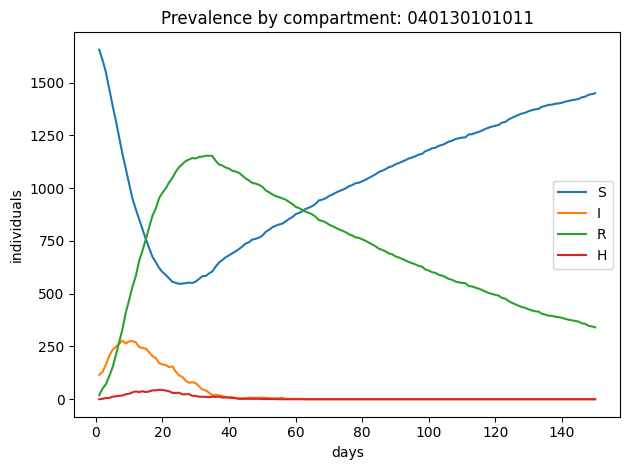

In [8]:
from typing import Sequence

from sympy import Max

from epymorph import *
from epymorph.compartment_model import *
from epymorph.compartment_model import ModelSymbols
from epymorph.simulation import AttributeDef

import numpy as np

from epymorph.geography.scope import CustomScope
from epymorph.geography.us_census import BlockGroupScope
from epymorph.adrio import acs5, us_tiger


class Sirh(CompartmentModel):
    compartments = [
        compartment("S"),
        compartment("I"),
        compartment("R"),
        compartment("H", tags=["immobile"]),
    ]

    requirements = [
        AttributeDef("beta", type=float, shape=Shapes.TxN),
        AttributeDef("gamma", type=float, shape=Shapes.TxN),
        AttributeDef("xi", type=float, shape=Shapes.TxN),
        AttributeDef("hospitalization_prob", type=float, shape=Shapes.TxN),
        AttributeDef("hospitalization_duration", type=float, shape=Shapes.TxN),
    ]

    def edges(self, symbols: ModelSymbols) -> Sequence[TransitionDef]:
        [S, I, R, H] = symbols.all_compartments
        [β, γ, ξ, h_prob, h_dur] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S + I + R + H)

        return [
            edge(S, I, rate=β * S * I / N),
            fork(
                edge(I, H, rate=γ * I * h_prob),
                edge(I, R, rate=γ * I * (1 - h_prob)),
            ),
            edge(H, R, rate=H / h_dur),
            edge(R, S, rate=ξ * R),
        ]


sirh_ipm = Sirh()

scope = BlockGroupScope.in_counties(counties_fips = ["04013"], year = 2019)

rume = SingleStrataRume.build(
    ipm=sirh_ipm,
    mm=mm_library["no"](),
    scope=scope,
    params={
        "beta": 0.45,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "population": acs5.Population(),
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    init=init.SingleLocation(location=0, seed_size=100),
)

sim = BasicSimulator(rume)
with sim_messaging():
    output = sim.run()

plot_pop(output, pop_idx=0)

# Expected Multistrada Model


## creating the scope


In [2]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
from sympy import Max

from epymorph import *
from epymorph.adrio import acs5, us_tiger
from epymorph.compartment_model import MultistrataModelSymbols, TransitionDef, edge
from epymorph.geography.us_census import BlockGroupScope
from epymorph.rume import MultistrataRumeBuilder
from epymorph.simulator.data import evaluate_param

maricopa_tracts = TractScope.in_counties(["04013"], year=2020)

subset_tracts = maricopa_tracts.get_node_ids()[::33][0:21]

scope = TractScope.in_tracts(subset_tracts.tolist())

print(f"The census tracts we'll model:\n{scope.get_node_ids()}")

In [3]:
scope = BlockGroupScope.in_counties(['04013'], year=2019)

print(f"The census tracts we'll model:\n{scope.get_node_ids()}")

The census tracts we'll model:
['040130101011' '040130101012' '040130101013' ... '040139805001'
 '040139806001' '040139807001']


## creating the multistrada model


In [56]:
from typing import Sequence

from sympy import Max

from epymorph import *
from epymorph.compartment_model import *
from epymorph.compartment_model import ModelSymbols
from epymorph.simulation import AttributeDef


class Sirh(CompartmentModel):
    compartments = [
        compartment('S'),
        compartment('E'),
        compartment('I'),
        compartment('R'),
        compartment('VS_1'),
        compartment('VR_1'),
        compartment('V_2'),
    ]

    requirements = [
        AttributeDef('beta_s_c', float, shape=Shapes.TxN),
        AttributeDef('beta_v_c', float, shape=Shapes.TxN),
        AttributeDef('alpha', float, shape=Shapes.TxN),
        AttributeDef('gamma', float, shape=Shapes.TxN),
        AttributeDef('omega', float, shape=Shapes.TxN),
    ]

    def edges(self, symbols: ModelSymbols) -> Sequence[TransitionDef]:
        [S, E, I, R, VS_1, VR_1, V_2] = symbols.all_compartments
        [β_s, β_v, α, γ, ω] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S, E, I, R, VS_1, VR_1, V_2)

        return [
            edge(S, E, rate = β_s * S * I / N),
            edge(E, I, rate = (1/α) * E),
            edge(I, R, rate = (1/γ) * I),
            
            edge(VS_1, E, rate = β_v * VS_1 * I / N),
            edge(VS_1, V_2, rate = ω * VS_1),
            
            edge(VR_1, V_2, rate = ω * V_2),
        ]


School_ipm = Sirh()

In [28]:
from pygris import (block_groups, counties, primary_secondary_roads,
                    school_districts, tracts)

In [21]:
STATE = input('Enter a State: ')
COUNTY = input('Enter a County: ')
YEAR = int(input('Enter a Year: '))

In [22]:
state_fips = '08'
county_fips = '029'
districts = school_districts(state="AZ", year=2019)
STATE = 'AZ'

Using FIPS code '04' for input 'AZ'


In [27]:
from census import Census
import os
import pandas as pd
import geopandas as gpd
import pygris


In [29]:
########################################################## Enduser Input #################################################################
crs_to_use = 'EPSG:4269' 


dir = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model')
powerpoint = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/powerpoints/School_movement_01-22-24')

census = Census('98a3a86a5708b65b92a50cc76d8d67280efbeb5d')

CentroidDType = np.dtype([('longitude', np.float64), ('latitude', np.float64)])

census_block_groups = block_groups(state=STATE, county=COUNTY, year=YEAR, cache=False)

census_block_groups = census_block_groups.to_crs(crs_to_use)

state_fips_list = census_block_groups['STATEFP'].unique()
county_fips_list = census_block_groups['COUNTYFP'].unique()

state_fips = ','.join(map(str, state_fips_list))
county_fips = ','.join(map(str, county_fips_list))
census_block_groups = census_block_groups[['GEOID', 'geometry', 'ALAND']]
CNTY = state_fips + county_fips

####################################################### Census #########################################################
AGE_VARS = [
    # School Age Population (Male): B01001_003-B01001_007
    "B01001_003E",  # Population (Male) 0-4 years
    "B01001_004E",  # Population (Male) 5-9 years
    "B01001_005E",  # Population (Male) 10-14 years
    "B01001_006E",  # Population (Male) 15-17 years
    "B01001_007E",  # Population (Male) 18-19 years
    # Adult Population (Male): B01001_008-B01001_016
    "B01001_008E",  # Population (Male) 20 years
    "B01001_009E",  # Population (Male) 21 years
    "B01001_010E",  # Population (Male) 22-24 years
    "B01001_011E",  # Population (Male) 25-29 years
    "B01001_012E",  # Population (Male) 30-34 years
    "B01001_013E",  # Population (Male) 35-39 years
    "B01001_014E",  # Population (Male) 40-44 years
    "B01001_015E",  # Population (Male) 45-49 years
    "B01001_016E",  # Population (Male) 50-54 years
    # Elder Population (Male): B01001_017-B01001_025
    "B01001_017E",  # Population (Male) 55-59 years
    "B01001_018E",  # Population (Male) 60-61 years
    "B01001_019E",  # Population (Male) 62-64 years
    "B01001_020E",  # Population (Male) 65-66 years
    "B01001_021E",  # Population (Male) 67-69 years
    "B01001_022E",  # Population (Male) 70-74 years
    "B01001_023E",  # Population (Male) 75-79 years
    "B01001_024E",  # Population (Male) 80-84 years
    "B01001_025E",  # Population (Male) 85+ years
    # School Age Population (Female): B01001_027-B01001_031
    "B01001_027E",  # Population (Female) 0-4 years
    "B01001_028E",  # Population (Female) 5-9 years
    "B01001_029E",  # Population (Female) 10-14 years
    "B01001_030E",  # Population (Female) 15-17 years
    "B01001_031E",  # Population (Female) 18-19 years
    # Adult Population (Female): B01001_032-B01001_040
    "B01001_032E",  # Population (Female) 20 years
    "B01001_033E",  # Population (Female) 21 years
    "B01001_034E",  # Population (Female) 22-24 years
    "B01001_035E",  # Population (Female) 25-29 years
    "B01001_036E",  # Population (Female) 30-34 years
    "B01001_037E",  # Population (Female) 35-39 years
    "B01001_038E",  # Population (Female) 40-44 years
    "B01001_039E",  # Population (Female) 45-49 years
    "B01001_040E",  # Population (Female) 50-54 years
    # Elder Population (Female): B01001_041-B01001_049
    "B01001_041E",  # Population (Female) 55-59 years
    "B01001_042E",  # Population (Female) 60-61 years
    "B01001_043E",  # Population (Female) 62-64 years
    "B01001_044E",  # Population (Female) 65-66 years
    "B01001_045E",  # Population (Female) 67-69 years
    "B01001_046E",  # Population (Female) 70-74 years
    "B01001_047E",  # Population (Female) 75-79 years
    "B01001_048E",  # Population (Female) 80-84 years
    "B01001_049E"   # Population (Female) 85+ years
]

SCHOOL_VARS = [
    "B14007_002E",  # Enrolled in nursery school, preschool
    "B14007_003E",  # Enrolled in kindergarten
    "B14007_004E",  # Enrolled in grade 1
    "B14007_005E",  # Enrolled in grade 2
    "B14007_006E",  # Enrolled in grade 3
    "B14007_007E",  # Enrolled in grade 4
    "B14007_008E",  # Enrolled in grade 5
    "B14007_009E",  # Enrolled in grade 6
    "B14007_010E",  # Enrolled in grade 7
    "B14007_011E",  # Enrolled in grade 8
    "B14007_012E",  # Enrolled in grade 9
    "B14007_013E",  # Enrolled in grade 10
    "B14007_014E",  # Enrolled in grade 11
    "B14007_015E",  # Enrolled in grade 12
]

# CBG data
query1 = {'for': 'block group: *',
          'in': f'state: {state_fips} county: {county_fips}'}
cbgs_raw = census.acs5.get([
    "B01003_001E",  # Total Population


], query1, year=YEAR)

cbgs_errollemt_raw = census.acs5.get(SCHOOL_VARS, query1, year=YEAR)
cbgs_age_raw = census.acs5.get(AGE_VARS, query1, year=YEAR)

cbgs_geog = pygris.block_groups(
    state=state_fips,
    county=county_fips,
    year=YEAR,
    cache=True
)

cbgs = pd.DataFrame.from_records(cbgs_raw)
cbgs.fillna(0, inplace=True)
cbgs.replace(-666666666, 0, inplace=True)

tract_geoids = cbgs['state'] + cbgs['county'] + cbgs['tract']
geoids = tract_geoids + cbgs['block group']

cbgs = pd.DataFrame({
    'geoid': geoids,
    'population': cbgs['B01003_001E'].astype(np.int64),
})

# Merge geo info
cbgs = cbgs.merge(pd.DataFrame({
    'geoid': cbgs_geog['GEOID'],
    'centroid': cbgs_geog['geometry'].apply(lambda row: row.centroid.coords[0]),
    # TIGER areas are in m^2; divide by 1e6 to get km^2
    'area': cbgs_geog.ALAND / 1e6
}), on='geoid')

cbgs.sort_values(by='geoid', inplace=True)
cbgs.reset_index(drop=True, inplace=True)

# Drop the same CBGs as above using an inner merge
cbgs_age = pd.DataFrame.from_records(cbgs_age_raw)
cbgs_age.astype(np.int64)

geoids = cbgs_age['state'] + cbgs_age['county'] + \
    cbgs_age['tract'] + cbgs_age['block group']
cbgs_age.insert(len(cbgs_age.columns), 'geoid', geoids)
cbgs_age = cbgs[['geoid']].merge(cbgs_age, how='inner', on='geoid')
cbgs_age.reset_index(drop=True, inplace=True)
cbgs_age.drop(columns=['geoid'], inplace=True)

def bracketize(brackets: dict[str, int]) -> pd.DataFrame:
    """Using the brackets info sum the age groups for both male and female."""
    sex_offset = sum(brackets.values())

    ranges = dict[str, tuple[slice, slice]]()
    age_offset = 0
    for key, count in brackets.items():
        i_m = age_offset
        i_f = age_offset + sex_offset
        ranges[key] = slice(i_m, i_m + count), slice(i_f, i_f + count)
        age_offset += count

    return pd.DataFrame({
        key: (cbgs_age.iloc[:, slice_m].sum(axis=1) +
              cbgs_age.iloc[:, slice_f].sum(axis=1))
        for key, (slice_m, slice_f) in ranges.items()
    }, dtype=np.int64)

cbgs_age_2 = bracketize({
    '00-19': 5,
    '20-54': 9,
    '55+': 9,
})

data = {
    'label': cbgs['geoid'].to_numpy(dtype=np.str_),
    'centroid': cbgs['centroid'].to_numpy(dtype=CentroidDType),
    'population': cbgs['population'].to_numpy(dtype=np.int64),
    'population_by_age': cbgs_age_2.to_numpy(dtype=np.int64),
}

census_df = pd.DataFrame({k: list(v) for k, v in data.items()})
census_block_groups = pd.merge(census_df, census_block_groups, left_on='label', right_on='GEOID')
census_block_groups = gpd.GeoDataFrame(census_block_groups, geometry=census_block_groups['geometry']).set_crs(epsg=4269, inplace=True)

census_df

Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'


,label,centroid,population,population_by_age
0,040130101011,"[-111.77075643330394, 33.76924660709943]",1791,"[358, 781, 652]"
1,040130101012,"[-111.72000671148204, 33.7410933260103]",2007,"[162, 423, 1422]"
2,040130101013,"[-111.66697569766907, 33.72404113568911]",1264,"[0, 22, 1242]"
3,040130101021,"[-111.49136471795472, 33.71546544071483]",1139,"[58, 413, 668]"
4,040130101022,"[-111.8505100649063, 33.82609833466325]",1487,"[110, 284, 1093]"
...,...,...,...,...
2500,040139801001,"[-112.88186166490277, 32.66947221385736]",0,"[0, 0, 0]"
2501,040139804001,"[-111.95879092988882, 33.298073567638134]",13,"[0, 9, 4]"
2502,040139805001,"[-111.88633119332626, 33.24392529871578]",0,"[0, 0, 0]"
2503,040139806001,"[-111.61909767565444, 33.33555256790642]",4291,"[1397, 2251, 643]"


In [30]:
census_df['population_by_age_school'] = census_df['population_by_age'].apply(lambda x: x[0])

school_explicit_df = census_df[['population_by_age_school', 'label']].copy()

school_explicit_df.columns = ['S', 'geoid']

school_explicit_df.loc[:, 'E'] = 0
school_explicit_df.loc[:, 'I'] = 0
school_explicit_df.loc[:, 'R'] = 0

infected_seed_locations = ['040134223021', '040134223042', '040134223053', '040134223072',
                           '040138149002', '040138150003', '040138154001', '040134226411',
                           '040134226412', '040134226422', '040134226431', '040134226432',
                           '040134226441', '040138144002', '040134225092', '040134224011',
                           '040138176001', '040134226061', '040134223082', '040134223083',
                           '040134224021', '040134223093', '040134224033', '040138154003',
                           '040134226171', '040134225093', '040134226213', '040134226222',
                           '040134226231', '040134226232', '040138146001', '040134225072',
                           '040134225103', '040134225112', '040134225122', '040134226062',
                           '040134226063', '040134226173', '040134226201']

initial_infected_size = np.zeros(len(infected_seed_locations))

total_infections = 1
np.random.seed(34)
random_indices = np.random.choice(len(initial_infected_size), size=total_infections, replace=True)
for index in random_indices:
    initial_infected_size[index] += 1

for geoid, infected_count in zip(infected_seed_locations, initial_infected_size):
    if geoid in school_explicit_df['geoid'].values:
        row_index = school_explicit_df[school_explicit_df['geoid'] == geoid].index[0]
        school_explicit_df.loc[row_index, 'I'] = infected_count

vaccinated_individuals = np.floor(school_explicit_df['S'] * 0.92).astype(int)
school_explicit_df.loc[:, 'VR_1'] = np.floor(vaccinated_individuals * 0.95).astype(int)
school_explicit_df.loc[:, 'VS_1'] = vaccinated_individuals - school_explicit_df['VR_1']
school_explicit_df.loc[:, 'V_2'] = 0
school_explicit_df.loc[:, 'S'] = school_explicit_df['S'] - vaccinated_individuals

indices = [school_explicit_df[school_explicit_df['geoid'] == geoid].index[0] for geoid in infected_seed_locations]

school_explicit_df = school_explicit_df[['S', 'E', 'I', 'R', 'VS_1', 'VR_1', 'V_2']]

school_initials_array = school_explicit_df.to_numpy(dtype=int)

school_initials_array[:5]

array([[ 29,   0,   0,   0,  17, 312,   0],
       [ 13,   0,   0,   0,   8, 141,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  5,   0,   0,   0,   3,  50,   0],
       [  9,   0,   0,   0,   6,  95,   0]])

In [32]:
import numpy as np

census_df['population_by_age_adults'] = census_df['population_by_age'].apply(lambda x: x[1])

adult_explicit_df = census_df[['population_by_age_adults', 'label']].copy()

adult_explicit_df.columns = ['S', 'geoid']

adult_explicit_df['E'] = 0
adult_explicit_df['I'] = 0
adult_explicit_df['R'] = 0

vaccinated_individuals = np.floor(adult_explicit_df['S'] * 0.92).astype(int)
adult_explicit_df['V_c'] = np.floor(vaccinated_individuals * 0.95).astype(int)

adult_explicit_df['S'] = adult_explicit_df['S'] - vaccinated_individuals

adult_explicit_df = adult_explicit_df[['S', 'E', 'I', 'R', 'V_c']]

adult_initials_array = adult_explicit_df.to_numpy(dtype=int)

adult_initials_array[:5]

array([[ 63,   0,   0,   0, 682],
       [ 34,   0,   0,   0, 369],
       [  2,   0,   0,   0,  19],
       [ 34,   0,   0,   0, 360],
       [ 23,   0,   0,   0, 247]])

In [57]:
class Sirh(CompartmentModel):
    compartments = [
        compartment('S'),
        compartment('E'),
        compartment('I'),
        compartment('R'),
        compartment('V_c'),
    ]

    requirements = [
        AttributeDef('beta_s_a', float, shape=Shapes.TxN),
        AttributeDef('beta_v_a', float, shape=Shapes.TxN),
        AttributeDef('alpha', float, shape=Shapes.TxN),
        AttributeDef('gamma', float, shape=Shapes.TxN),
        AttributeDef('omega', float, shape=Shapes.TxN),
    ]

    def edges(self, symbols: ModelSymbols) -> Sequence[TransitionDef]:
        [S, E, I, R, V_c] = symbols.all_compartments
        [β_s, β_v, α, γ, ω] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S, E, I, R, V_c)

        return [
            edge(S, E, rate = β_s * S * I / N),
            edge(E, I, rate = (1/α) * E),
            edge(I, R, rate = (1/γ) * I),
            
            edge(V_c, E, rate = β_v * V_c * I / N),
        ]


Adult_ipm = Sirh()

In [59]:
class Sirh(CompartmentModel):
    compartments = [
        compartment('S'),
        compartment('E'),
        compartment('I'),
        compartment('R'),
        compartment('V_c'),
    ]

    requirements = [
        AttributeDef('beta_s_s', float, shape=Shapes.TxN),
        AttributeDef('beta_v_s', float, shape=Shapes.TxN),
        AttributeDef('alpha', float, shape=Shapes.TxN),
        AttributeDef('gamma', float, shape=Shapes.TxN),
        AttributeDef('omega', float, shape=Shapes.TxN),
    ]

    def edges(self, symbols: ModelSymbols) -> Sequence[TransitionDef]:
        [S, E, I, R, V_c] = symbols.all_compartments
        [β_s, β_v, α, γ, ω] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S, E, I, R, V_c)

        return [
            edge(S, E, rate = β_s * S * I / N),
            edge(E, I, rate = (1/α) * E),
            edge(I, R, rate = (1/γ) * I),
            
            edge(V_c, E, rate = β_v * V_c * I / N),
        ]


Senior_ipm = Sirh()

In [35]:
census_df['population_by_age_senior'] = census_df['population_by_age'].apply(lambda x: x[2])

senior_explicit_df = census_df[['population_by_age_senior', 'label']].copy()

senior_explicit_df = census_df[['population', 'label']].copy()

senior_explicit_df.columns = ['S', 'geoid']

senior_explicit_df['E'] = 0
senior_explicit_df['I'] = 0
senior_explicit_df['R'] = 0

vaccinated_individuals = np.floor(senior_explicit_df['S'] * 0.92).astype(int)
senior_explicit_df['V_c'] = np.floor(vaccinated_individuals * 0.95).astype(int)
senior_explicit_df['V_b'] = 0  # Initialize 'V_b' to 0
senior_explicit_df['S'] = senior_explicit_df['S'] - vaccinated_individuals

senior_explicit_df = senior_explicit_df[['S', 'E', 'I', 'R', 'V_c', 'V_b']]
senior_initials_array = senior_explicit_df.to_numpy(dtype=int)

senior_initials_array[:5]

array([[ 144,    0,    0,    0, 1564,    0],
       [ 161,    0,    0,    0, 1753,    0],
       [ 102,    0,    0,    0, 1103,    0],
       [  92,    0,    0,    0,  994,    0],
       [ 119,    0,    0,    0, 1299,    0]])

In [73]:
class MyRume(MultistrataRumeBuilder):
    strata = [
        Gpm(
            name="age_00-19",
            ipm=School_ipm,
            mm=mm_library["centroids"](),
            init=init.SingleLocation(location=0, seed_size=100)
        ),
        Gpm(
            name="age_20-59",
            ipm=ipm_library["sirs"](),
            mm=mm_library["centroids"](),
            init=init.NoInfection(),
        ),
        Gpm(
            name="age_60-79",
            ipm=ipm_library["sirs"](),
            mm=mm_library["centroids"](),
            init=init.NoInfection(),
        ),
    ]

    meta_requirements = [
        AttributeDef("beta_12", float, Shapes.TxN),
        AttributeDef("beta_13", float, Shapes.TxN),
        AttributeDef("beta_21", float, Shapes.TxN),
        AttributeDef("beta_23", float, Shapes.TxN),
        AttributeDef("beta_31", float, Shapes.TxN),
        AttributeDef("beta_32", float, Shapes.TxN),
    ]

    def meta_edges(self, symbols: MultistrataModelSymbols) -> list[TransitionDef]:
        # extract compartment symbols by strata
        S_1, I_1, E_1, R_1, VS_1, VR_1, V_1 = symbols.strata_compartments("age_00-19")
        S_2, I_2, R_2 = symbols.strata_compartments("age_20-59")
        S_3, I_3, R_3 = symbols.strata_compartments("age_60-79")

        # extract compartment totals by strata
        N_1 = Max(1, S_1 + I_1 + E_1 + R_1 + + VS_1 + VR_1 + V_1)
        N_2 = Max(1, S_2 + I_2 + R_2)
        N_3 = Max(1, S_3 + I_3 + R_3)

        # extract meta attributes
        beta_12, beta_13, beta_21, beta_23, beta_31, beta_32 = (
            symbols.all_meta_requirements
        )

        return [
            edge(S_1, I_1, rate=S_1 * beta_12 * I_2 / N_2),  # 2 infects 1
            edge(S_1, I_1, rate=S_1 * beta_13 * I_3 / N_3),  # 3 infects 1
            edge(S_2, I_2, rate=S_2 * beta_21 * I_1 / N_1),  # 1 infects 2
            edge(S_2, I_2, rate=S_2 * beta_23 * I_3 / N_3),  # 3 infects 2
            edge(S_3, I_3, rate=S_3 * beta_31 * I_1 / N_1),  # 1 infects 3
            edge(S_3, I_3, rate=S_3 * beta_32 * I_2 / N_2),  # 2 infects 3
        ]

## creating the multistrada parameters


In [81]:
rume = MyRume().build(
    scope=scope,
    time_frame=TimeFrame.of("2020-01-01", 265),
    params={
        # IPM params
        "gpm:age_00-19::ipm::beta_s_c": 0.65,
        "gpm:age_20-59::ipm::beta": 0.10,
        "gpm:age_60-79::ipm::beta": 0.35,

        "gpm:age_00-19::ipm::beta_v_c": 0.05,
    
        "*::ipm::gamma": 1 / 10,
        "*::ipm::alpha": 1 / 90,
        "*::ipm::omega": 1 / 90,
        "*::ipm::xi": 1 / 90,

        "meta::ipm::beta_12": 0.05,
        "meta::ipm::beta_13": 0.05,
        "meta::ipm::beta_21": 0.20,
        "meta::ipm::beta_23": 0.20,
        "meta::ipm::beta_31": 0.35,
        "meta::ipm::beta_32": 0.35,
        # MM params
        "gpm:age_00-19::mm::phi": 20.0,
        "gpm:age_20-59::mm::phi": 40.0,
        "gpm:age_60-79::mm::phi": 30.0,
        # ADRIO things!
        "*::*::centroid": us_tiger.InternalPoint(),
        "*::*::population_by_age_table": acs5.PopulationByAgeTable(),
        "gpm:age_00-19::*::population": acs5.PopulationByAge(0, 19),
        "gpm:age_20-59::*::population": acs5.PopulationByAge(20, 59),
        "gpm:age_60-79::*::population": acs5.PopulationByAge(60, 79),
    },
)

## runing the multistrada model


ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`...ADRIO PopulationByAgeTable fetching `gpm:age_00-19::mm::population_by_age_table`... done (0.000 seconds)
 done (0.000 seconds)
 done (0.000 seconds)
 done (0.000 seconds)

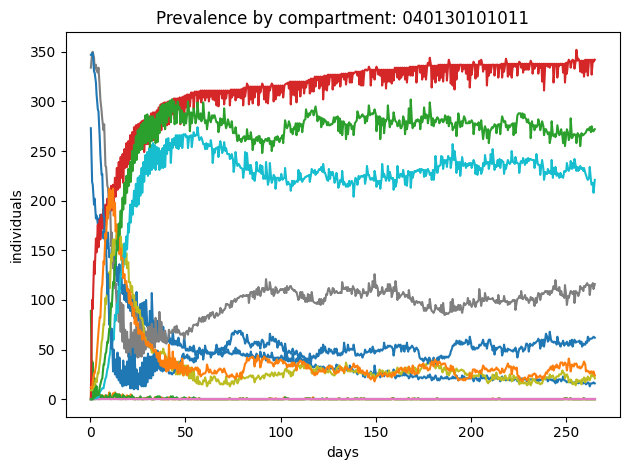

In [82]:
sim = BasicSimulator(rume)
with sim_messaging():
    out = sim.run()
    
plot_pop(out, pop_idx=0)

# Monsoon Results

Once monsoon has finish your "jobs" you are left with n amount of simulated data provide for EpyMoRPH. The goal of this sections is to complie your results into something useful wiht the provide output.


In [ ]:
import os 

Monsoon_directory = 'replace with path to directory'

In [83]:
# calc total new infections (depending on the IPM this may represent this as separate events)
infection_events = [
    rume.ipm.events_by_dst("I_age_00-19"),
    rume.ipm.events_by_dst("I_age_20-59"),
    rume.ipm.events_by_dst("I_age_60-79"),
]

infections = np.array(
    [
        reduce(
            lambda a, b: a + b,
            (out.incidence_per_day[:, :, j].sum(axis=1) for j in infection_events[i]),
        )
        for i in [0, 1, 2]
    ]
)

### GRAPHS


In [6]:
pop_00_19 = evaluate_param(rume, "gpm:age_00-19::_::population")
pop_20_59 = evaluate_param(rume, "gpm:age_20-59::_::population")
pop_60_79 = evaluate_param(rume, "gpm:age_60-79::_::population")

# Plot infections by age class
age_label = ["age [0,20)", "age [20,60)", "age [60,80)"]
age_total_thousands = np.array([pop_00_19, pop_20_59, pop_60_79]).sum(axis=1) / 1000
t_window = slice(0, None)

NameError: name 'evaluate_param' is not defined

In [2]:
import numpy as np

In [3]:
# Day of Peak Infection by age class
dpi = [int(np.argmax(infections[i])) for i in [0, 1, 2]]
max_y_value = infections.max()
dpi_x_pos = 80  # an absolute x offset (to keep them horizontally aligned)
dpi_y_pos = -0.025 * max_y_value  # an offset from the peak's y position
age_label = ['Adult', 'Seniors', 'Childern']
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 6))
x_axis = np.arange(out.dim.days)[t_window]

ax1.set_title("New infections by age class")
ax1.set_ylabel("occurrences")
for i in [0, 1, 2]:
    color = ax1._get_lines.get_next_color()
    y_axis = infections[i][t_window]
    ax1.plot(x_axis, y_axis, color=color, label=age_label[i])
    # Mark day of peak infection
    d = dpi[i]
    ax1.text(dpi_x_pos, y_axis[d] + dpi_y_pos, f"day {d}", color=color)
    ax1.hlines(
        y=y_axis[d],
        xmin=d,
        xmax=dpi_x_pos - 1,
        color=color,
        linewidth=0.5,
        linestyle="dashed",
    )
ax1.legend()

ax2.set_title("New infections by age class (per thousand)")
ax2.set_xlabel("days")
ax2.set_ylabel("occurrences per thousand")
for i in [0, 1, 2]:
    y_axis = infections[i][t_window] / age_total_thousands[i]
    ax2.plot(x_axis, y_axis, label=age_label[i])
ax2.legend()

fig.tight_layout()
plt.show()

NameError: name 'infections' is not defined

In [4]:
# Plot infections by location
pop_total_thousands = (pop_00_19 + pop_20_59 + pop_60_79) / 1000

t_window = slice(0, 50)

infections_by_loc = out.incidence_per_day[:, :, rume.ipm.events_by_dst("I_age_*")].sum(
    axis=2, dtype=np.int64
)

fig, ax = plt.subplots(figsize=(8, 6))
x_axis = np.arange(out.dim.days)[t_window]
ax.set_title("New infections by location (per thousand)")
ax.set_xlabel("days")
ax.set_ylabel("occurrences per thousand")
for n in range(rume.dim.nodes):
    y_axis = infections_by_loc[t_window, n] / pop_total_thousands[n]
    ax.plot(x_axis, y_axis, linewidth=0.8)

fig.tight_layout()
plt.show()

NameError: name 'pop_00_19' is not defined